In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import re
import string
# fix random seed for reproducibility
np.random.seed(7)
%matplotlib inline  
%load_ext autoreload
%autoreload 2

Loading the wikipedia pages articles 

In [2]:
politics_data = pd.read_csv("politics_full.csv")
sports_data = pd.read_csv("sports_full.csv")
history_data = pd.read_csv("history_full.csv")
culture_data = pd.read_csv("culture_full.csv")
comp_science_data = pd.read_csv("comp_science_full.csv")

Mapping different categories to integers

In [3]:
category_dict = {
    1: 'politics',
    2: 'sports',
    3: 'history',
    4: 'culture',
    5: 'computer_science'
}

Removing newlines and punctuations from raw content of the pages

In [4]:
translator = str.maketrans('', '', string.punctuation)
politics_data['content'] = politics_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
politics_data['category'] = [1]* len(politics_data)

sports_data['content'] = sports_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
sports_data['category'] = [2]* len(sports_data)

history_data['content'] = history_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
history_data['category'] = [3]* len(history_data)

culture_data['content'] = culture_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
culture_data['category'] = [4]* len(culture_data)

comp_science_data['content'] = comp_science_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
comp_science_data['category'] = [5]* len(comp_science_data)


In [5]:
comp_science_data.head()

,Unnamed: 0,title,pageid,length,content,category
0,0,Artificial intelligence,1164,231620,Artificial intelligence AI also machine intell...,5
1,1,Comparison of programming languages (string fu...,3681422,109570,String functions are used in computer programm...,5
2,2,Geographic information system,12398,77692,A geographic information system GIS is a syste...,5
3,3,Computational creativity,16300571,61153,Computational creativity also known as artific...,5
4,4,Computational phylogenetics,3986130,58742,Computational phylogenetics is the application...,5


Union the 5 dataframes and make a new dataframe

In [6]:
#union data frames
df_list = [politics_data, sports_data, history_data, culture_data, comp_science_data]
full_df = pd.concat(df_list)

In [7]:
#shuffling the rows of dataframe
full_df = full_df.sample(frac=1)

In [8]:
contents = list(full_df['content'])
targets = np.array(full_df['category'])

making the TF IDF matrix of the documents. We choose to remove the words that appear in less than 5 documnets in the corpus.

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=5)
#vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(contents)
vectors.shape

(5000, 31700)

As we can see the resulting matrix is relatively sparse

In [10]:
print('total number of zeros:', vectors.nnz)
print('{} average zero per data sample'.format(vectors.nnz / float(vectors.shape[0])))

total number of zeros: 1505991
301.1982 average zero per data sample


It is desirable to have equal number of samples in both training and test corpus. So we first shuffle the indicies for each of the classes and then we pick 90% data from each of the classes for training and 10% for testing.

In [11]:
indicies_1 = [i for i,x in enumerate(targets) if x == 1]
np.random.shuffle(indicies_1)
indicies_2 = [i for i,x in enumerate(targets) if x == 2]
np.random.shuffle(indicies_2)
indicies_3 = [i for i,x in enumerate(targets) if x == 3]
np.random.shuffle(indicies_3)
indicies_4 = [i for i,x in enumerate(targets) if x == 4]
np.random.shuffle(indicies_4)
indicies_5 = [i for i,x in enumerate(targets) if x == 5]
np.random.shuffle(indicies_5)

In [12]:
ratio = 0.9
train_indicies = indicies_1[0:int(ratio*len(indicies_1))]\
+indicies_2[0:int(ratio*len(indicies_2))]+indicies_3[0:int(ratio*len(indicies_3))]\
+indicies_4[0:int(ratio*len(indicies_4))]+indicies_5[0:int(ratio*len(indicies_5))]
np.random.shuffle(train_indicies)

In [13]:
test_indicies = indicies_1[int(ratio*len(indicies_1)):]\
+indicies_2[int(ratio*len(indicies_2)):]+indicies_3[int(ratio*len(indicies_3)):]\
+indicies_4[int(ratio*len(indicies_4)):]+indicies_5[int(ratio*len(indicies_5)):]
np.random.shuffle(test_indicies)

final training and test vectors

In [14]:
train_vectors = vectors[train_indicies]
test_vectors = vectors[test_indicies]
#------------
train_targets = targets[train_indicies]
test_targets = targets[test_indicies]

In [15]:
feature_names = vectorizer.get_feature_names()
feature_names[:5]

['00', '000', '0000', '001', '007']

## Random forest Classifier

Fisrt we choose to train a random forest classifier

In [160]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_jobs=-1)
RFclassifier.fit(train_vectors,train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [161]:
test_res = RFclassifier.predict(test_vectors)

In [162]:
accuracy = np.mean([test_res[i]==test_targets[i] for i in range(len(test_targets))])
print('accuracy = {}%'.format(accuracy*100))

accuracy = 74.6%


Hyperparameter tuning for Random Forest parameters

In [163]:
from sklearn.model_selection import GridSearchCV, cross_val_score
n_estimator = [i for i in range(100,1100,100)]
max_depth = [i for i in range(50,100,10)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},n_jobs=-1)
clf.fit(train_vectors,train_targets)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [50, 60, 70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The dataframe below shows the best train and test score and their associated parameters

In [164]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)
df.head()

/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.wa

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
29,163.670287,7.145987,0.821556,0.990333,70,1000,"{'max_depth': 70, 'n_estimators': 1000}",1,0.814667,0.992333,0.823333,0.990333,0.826667,0.988333,11.686875,1.077985,0.005058,0.001633
8,125.858999,6.559073,0.821111,0.989222,50,900,"{'max_depth': 50, 'n_estimators': 900}",2,0.813333,0.991667,0.825333,0.990000,0.824667,0.986000,1.134310,0.123111,0.005506,0.002378
9,150.759535,7.794189,0.821111,0.989111,50,1000,"{'max_depth': 50, 'n_estimators': 1000}",2,0.814667,0.991667,0.823333,0.989667,0.825333,0.986000,7.780510,0.247463,0.004629,0.002347
16,119.400220,5.967087,0.821111,0.989778,60,700,"{'max_depth': 60, 'n_estimators': 700}",2,0.814000,0.992000,0.830000,0.990333,0.819333,0.987000,5.114454,0.159478,0.006652,0.002079
18,157.372489,7.499259,0.820889,0.989778,60,900,"{'max_depth': 60, 'n_estimators': 900}",5,0.814667,0.992000,0.826667,0.990333,0.821333,0.987000,2.454800,0.460805,0.004909,0.002079


In [165]:
best_RFclassifier = RandomForestClassifier(n_estimators=1000, max_depth=70, n_jobs=-1)
best_RFclassifier.fit(train_vectors,train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
print('accuracy for best RF classifier = {}%'.format(best_RFclassifier.score(test_vectors, test_targets)*100))

accuracy for best RF classifier = 82.8%


## Naive Bayes Classifier

Second classifier is Multinomial Naive Classifier

In [198]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, train_targets)

In [199]:
print('accuracy for Multinomial Naive Bayes classifier = {}%'.format(clf.score(test_vectors, test_targets)*100))

accuracy for Multinomial Naive Bayes classifier = 84.0%


Tuning $\alpha $ parameter for the classifier

In [208]:
alpha = [i/10 for i in range(1,20,1)]
clf = GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha':alpha},n_jobs=-1, cv=10, return_train_score=True)
clf.fit(train_vectors,train_targets)

GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [209]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.337634,0.010722,0.845778,0.933333,0.2,{'alpha': 0.2},1,0.866667,0.933333,0.853333,...,0.853333,0.931605,0.831111,0.934074,0.851111,0.933086,0.023646,0.002840,0.012500,0.001059
0,0.236525,0.008792,0.843333,0.940889,0.1,{'alpha': 0.1},2,0.860000,0.940741,0.851111,...,0.848889,0.938272,0.831111,0.940000,0.848889,0.940247,0.105323,0.004253,0.010669,0.001646
2,0.307943,0.011466,0.842889,0.927333,0.3,{'alpha': 0.3},3,0.866667,0.927654,0.842222,...,0.855556,0.925679,0.824444,0.927901,0.842222,0.927654,0.019358,0.002061,0.012998,0.001018
3,0.295297,0.012531,0.840000,0.922123,0.4,{'alpha': 0.4},4,0.862222,0.923951,0.833333,...,0.853333,0.920000,0.817778,0.922222,0.833333,0.923210,0.023494,0.001517,0.013481,0.001750
4,0.229445,0.008891,0.838222,0.917654,0.5,{'alpha': 0.5},5,0.851111,0.918519,0.835556,...,0.851111,0.915802,0.820000,0.918272,0.831111,0.919012,0.091586,0.003984,0.010968,0.001185


In [212]:
best_NB = MultinomialNB(alpha=0.2).fit(train_vectors, train_targets)
print('accuracy for best Multinomial Naive Bayes classifier = {}%'.format(best_NB.score(test_vectors, test_targets)*100))

accuracy for best Multinomial Naive Bayes classifier = 84.8%


## Logistic Regression

Training a multiclass Logestic Regression for the task. We use the Logistic Regression cross validation function. The rgularization parameter will vary between $10ˆ{-4}$ and $10ˆ{4}$. We choose to have 20 different values in this interval

In [215]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(Cs=20, multi_class='multinomial', n_jobs=-1)
clf.fit(train_vectors, train_targets)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [248]:
print('accuracy for best Logistic Regression classifier = {}%'.format(clf.score(test_vectors, test_targets)*100))

accuracy for best Logistic Regression classifier = 87.8%


In [236]:
scors = np.concatenate((np.mean(clf.scores_[1], axis = 0), np.mean(clf.scores_[2], axis = 0)
                        , np.mean(clf.scores_[3], axis = 0), np.mean(clf.scores_[4], axis = 0)
                        , np.mean(clf.scores_[5], axis = 0)), axis=0)
scors = scors.reshape((5,20))

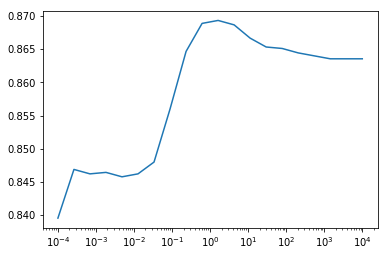

In [241]:
plt.semilogx(clf.Cs_, np.mean(scors, axis=0))
plt.show()


In [249]:
from sklearn.metrics import confusion_matrix
test_res = clf.predict(test_vectors)
cnf_matrix = confusion_matrix(test_targets, test_res)

Confusion matrix, without normalization


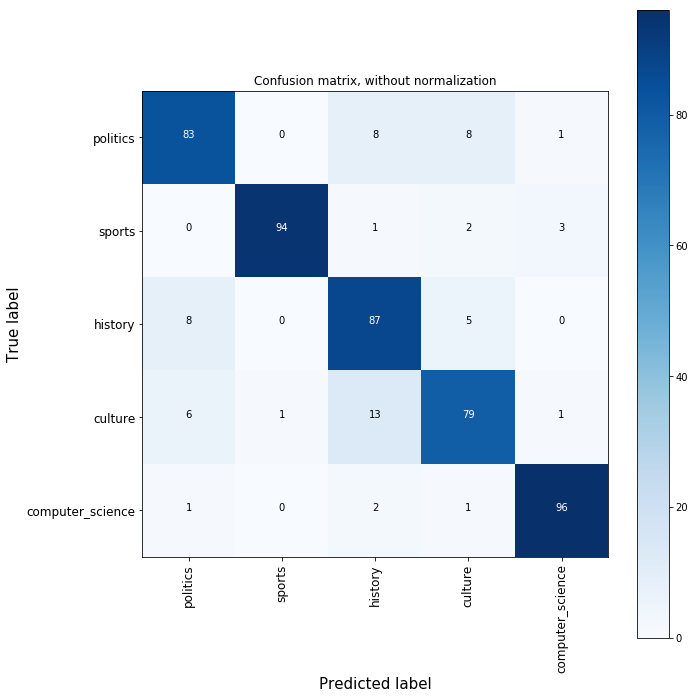

In [252]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category_dict))
    plt.xticks(tick_marks, category_dict.values(), rotation=90,fontsize=12)
    plt.yticks(tick_marks, category_dict.values(), fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')

The confusion matrix show wich classes where misclassified with each other. As expected similar categories (culture, politics and history) were misclassified mostly.

## Deep Learning

We start the deep learning part here. We will use Keras library on Tensorflow backend.

In [16]:
import keras
import tensorflow

/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
from gensim.models import Word2Vec

For the deep learning part we will use word embeddings as they are proved to give better results compared to one hot word vectors. So we start to tokenize the text again with nltk library and remove the stop words. We also lower case all of the words.

In [18]:
import nltk
tokenized = [nltk.word_tokenize(text) for text in contents]

In [19]:
from nltk.corpus import stopwords
# punctuation = string.punctuation+'“’—.”’“--,”' # pimp the list of punctuation to remove
def rem_stop(txt,stop_words=stopwords.words("english"),lower=True):
    """
    Removes stopwords and other things from a text, inc. numbers
    :param list txt: text tokens (list of str)
    :param list stop_words: stopwords to remove (list of str)
    :param bol lower: if to lowercase
    """
    if lower:
        return [t.lower() for t in txt if t.lower() not in stop_words and not t.isdigit()]
    else:
        return [t for t in txt if t.lower() not in stop_words and not t.isdigit()]

In [20]:
corpus = [rem_stop(tokens) for tokens in tokenized]

In [21]:
embedding_model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=-1, iter=200)

In [435]:
embedding_model.wv.most_similar(positive=['france', 'paris'], negative=['germany'])

[('post1970s', 0.45103001594543457),
 ('lacierda', 0.4451066255569458),
 ('forgacs', 0.4363461434841156),
 ('repealing', 0.4331750273704529),
 ('interregnums', 0.4275933504104614),
 ('u818', 0.421070396900177),
 ('abcdef', 0.4119409918785095),
 ('doi10100735404755597', 0.39712589979171753),
 ('welsch', 0.396402508020401),
 ('commandinchief', 0.391961932182312)]

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, LSTM, Conv1D, Flatten, Dropout
from keras.layers.merge import Concatenate, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [23]:
MAX_SEQUENCE_LENGTH = 5000
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# 0 is a reserved index that won't be assigned to any word
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(targets-1))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 175282 unique tokens.
Shape of data tensor: (5000, 5000)
Shape of label tensor: (5000, 5)


In [24]:
len(embedding_model.wv.vocab.keys())

175282

In [25]:
x_train = data[train_indicies]
y_train = labels[train_indicies]
x_test = data[test_indicies]
y_test = labels[test_indicies]

In [440]:
# EMBEDDING_DIM = 100
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embedding_model.wv.vocab.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_model.wv[word]

In [26]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [27]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [472]:
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

In [473]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(category_dict), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_split=0.1, 
          epochs=10, batch_size=512, callbacks=[ckpt_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/10
4050/4050 [==============================] - 47s 12ms/step - loss: 4.7758 - acc: 0.3551 - val_loss: 2.6198 - val_acc: 0.5200

Epoch 00001: val_loss improved from inf to 2.61980, saving model to keras_model
Epoch 2/10
4050/4050 [==============================] - 46s 11ms/step - loss: 1.3508 - acc: 0.6733 - val_loss: 0.9727 - val_acc: 0.6578

Epoch 00002: val_loss improved from 2.61980 to 0.97270, saving model to keras_model
Epoch 3/10
4050/4050 [==============================] - 46s 11ms/step - loss: 0.7054 - acc: 0.7919 - val_loss: 0.7638 - val_acc: 0.7600

Epoch 00003: val_loss improved from 0.97270 to 0.76383, saving model to keras_model
Epoch 4/10
4050/4050 [==============================] - 47s 11ms/step - loss: 0.4252 - acc: 0.8716 - val_loss: 0.8615 - val_acc: 0.6778

Epoch 00004: val_loss did not improve
Epoch 5/10
4050/4050 [==============================] - 46s 11ms/step - loss: 0.3324 - acc: 0.8973 - val_loss: 0.4882 -

In [503]:
keras_model = load_model('keras_model')
keras_model.evaluate(x_test, y_test)

500/500 [==============================] - 3s 5ms/step


[0.5528527736663819, 0.83]

In [484]:
# embed_dim = 100
lstm_out = 196

# Model saving callback
lstm_callback = ModelCheckpoint('lstm_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(5,activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['acc'])
print(lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5000, 100)         17528300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               232848    
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 985       
Total params: 17,762,133
Trainable params: 17,762,133
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
lstm_model.fit(x_train, y_train, validation_split=0.1, verbose=1,
          epochs=20, batch_size=512, callbacks=[lstm_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/20
4050/4050 [==============================] - 224s 55ms/step - loss: 1.4419 - acc: 0.4627 - val_loss: 1.1370 - val_acc: 0.6400

Epoch 00001: val_loss improved from inf to 1.13701, saving model to lstm_model
Epoch 2/20
4050/4050 [==============================] - 219s 54ms/step - loss: 0.8628 - acc: 0.7143 - val_loss: 0.7540 - val_acc: 0.7156

Epoch 00002: val_loss improved from 1.13701 to 0.75403, saving model to lstm_model
Epoch 3/20
4050/4050 [==============================] - 219s 54ms/step - loss: 0.6125 - acc: 0.7812 - val_loss: 0.6536 - val_acc: 0.7667

Epoch 00003: val_loss improved from 0.75403 to 0.65361, saving model to lstm_model
Epoch 4/20
4050/4050 [==============================] - 221s 55ms/step - loss: 0.4946 - acc: 0.8281 - val_loss: 0.5911 - val_acc: 0.7844

Epoch 00004: val_loss improved from 0.65361 to 0.59115, saving model to lstm_model
Epoch 5/20
4050/4050 [==============================] - 220s 54ms/step - 

In [486]:
best_lstm_model = load_model('lstm_model')
best_lstm_model.evaluate(x_test, y_test)

500/500 [==============================] - 33s 66ms/step


[0.5823710279464722, 0.8100000004768372]

In [498]:
embedding_layer1 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
cnn = Sequential()
cnn.add(embedding_layer1)
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(MaxPooling1D(5))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

lstm_out = 196

lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))

merged = Merge([cnn, lstm], mode='concat')

merged_model = Sequential()
merged_model.add(merged)
merged_model.add(Dense(len(category_dict), activation='softmax'))
# merged_model.add(Dropout(0.5))
# merged_model.add(Dense(28, activation='relu'))
# merged_model.add(Dense(input_dim=10, output_dim=classes))
# merged_model.add(Activation("softmax"))
merged_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['acc'])
print(merged_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_4 (Merge)              (None, 324)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 1625      
Total params: 51,722,945
Trainable params: 51,722,945
Non-trainable params: 0
_________________________________________________________________
None


/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [502]:
merged_callback = ModelCheckpoint('merged_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
merged_model.fit([x_train, x_train], y_train, validation_split=0.1, verbose=1,
          epochs=10, batch_size=512, callbacks=[merged_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/10
4050/4050 [==============================] - 250s 62ms/step - loss: 4.4642 - acc: 0.3007 - val_loss: 2.4140 - val_acc: 0.3711

Epoch 00001: val_loss improved from inf to 2.41395, saving model to merged_model
Epoch 2/10
4050/4050 [==============================] - 243s 60ms/step - loss: 1.7234 - acc: 0.5521 - val_loss: 1.0846 - val_acc: 0.6711

Epoch 00002: val_loss improved from 2.41395 to 1.08465, saving model to merged_model
Epoch 3/10
4050/4050 [==============================] - 246s 61ms/step - loss: 0.7507 - acc: 0.7598 - val_loss: 0.6483 - val_acc: 0.7733

Epoch 00003: val_loss improved from 1.08465 to 0.64834, saving model to merged_model
Epoch 4/10
4050/4050 [==============================] - 246s 61ms/step - loss: 0.4488 - acc: 0.8627 - val_loss: 0.6033 - val_acc: 0.7867

Epoch 00004: val_loss improved from 0.64834 to 0.60331, saving model to merged_model
Epoch 5/10
4050/4050 [==============================] - 246s 61ms

In [513]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
# x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = LSTM(lstm_out, recurrent_dropout=0.25, dropout=0.25)(x)
preds = Dense(len(category_dict), activation='softmax')(x)

mixed_model = Model(sequence_input, preds)
mixed_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['acc'])



In [ ]:
mixed_callback = ModelCheckpoint('mixed_model1', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
# happy learning!
mixed_model.fit(x_train, y_train, validation_split=0.1, 
          epochs=15, batch_size=512, callbacks=[mixed_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/15
4050/4050 [==============================] - 86s 21ms/step - loss: 1.3689 - acc: 0.4881 - val_loss: 0.8911 - val_acc: 0.7267

Epoch 00001: val_loss improved from inf to 0.89108, saving model to mixed_model1
Epoch 2/15
4050/4050 [==============================] - 84s 21ms/step - loss: 0.5549 - acc: 0.8341 - val_loss: 0.5255 - val_acc: 0.8400

Epoch 00002: val_loss improved from 0.89108 to 0.52550, saving model to mixed_model1
Epoch 3/15
4050/4050 [==============================] - 83s 21ms/step - loss: 0.2463 - acc: 0.9175 - val_loss: 0.6100 - val_acc: 0.8178

Epoch 00003: val_loss did not improve
Epoch 4/15
4050/4050 [==============================] - 84s 21ms/step - loss: 0.1408 - acc: 0.9600 - val_loss: 0.6401 - val_acc: 0.8156

Epoch 00004: val_loss did not improve
Epoch 5/15
4050/4050 [==============================] - 84s 21ms/step - loss: 0.0865 - acc: 0.9709 - val_loss: 0.6233 - val_acc: 0.8067

Epoch 00005: val_loss did 

In [516]:
best_mixed_model = load_model('mixed_model1')
best_mixed_model.evaluate(x_test, y_test)

500/500 [==============================] - 8s 16ms/step


[0.5140607929229737, 0.7899999995231628]

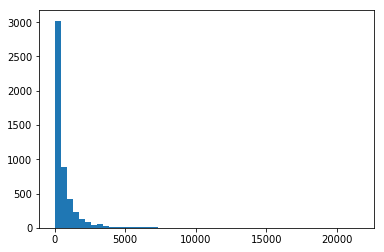

In [353]:
l = [len(t) for t in corpus]
plt.hist(l, bins=50);

In [29]:
best_cnn_model = load_model('best_cnn_model')
best_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 100)         17528300  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4996, 100)         50100     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 999, 100)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 999, 100)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 99900)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               12787328  
__________

In [30]:
best_cnn_model.evaluate(x_test,y_test)

500/500 [==============================] - 1s 3ms/step


[0.642090087890625, 0.8160000009536743]